# 好的优化器能够提高收敛速度

SGD是最基本的优化器

Momentum是在SGD基础上加入了动量考虑的优化器

RMSprop

Adam是综合了Momentum和RMSprop的优化器

上述的四种都是“算法”

In [32]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data # 用于分组训练的库
import torch.nn.functional as F # 激活函数用的库

超参数（常量）

In [33]:
LR = 0.01 # 学习率
BATCH_SIZE = 32 # 一组容量，分组训练也会提高收敛速度（或者说，训练速度）
EPOCHS = 12 # 训练轮数

## 制作数据

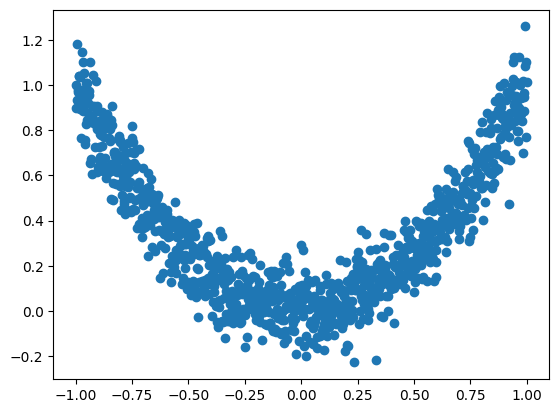

In [34]:
x = torch.linspace(-1, 1, 1000).unsqueeze(dim = 1)
y = x.pow(2)+0.1*torch.normal(torch.zeros(x.size()))

plt.scatter(x, y)
plt.show()

## 分组器

In [35]:
torch_dataset = data.TensorDataset(x,y) # x和y会一一对应，后面的shuffle洗牌会保持这种一一对应关系
print(f"x是{x.size()},y是{y.size()}")
loader = data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

x是torch.Size([1000, 1]),y是torch.Size([1000, 1])


## 定义一个神经网络

从这里就能对比出来对象化创建和快速创建的区别，

在想要创建多个相同结构的神经网络时，快速创建会产生大量的代码重复。

想用使用快速创建的方法，创建多个相同结构的神经网络，可以使用copy.deepcopy(变量)，或者torch.nn.ModuleList([Sequential for _ in range(数量)])

In [36]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)

    def forward(self,x):
        return self.predict(F.relu(self.hidden(x)))

In [37]:
# 声明模型
net_SGD = Net()
net_Momentm= Net()
net_RMSprop= Net()
net_Adam = Net()
nets = [net_SGD ,net_Momentm, net_RMSprop, net_Adam]

# 声明优化器
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentm = torch.optim.SGD(net_Momentm.parameters(), lr=LR, momentum=0.8)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.999))
opts = [opt_SGD, opt_Momentm, opt_RMSprop, opt_Adam]

# 声明损失函数
loss_func = torch.nn.MSELoss()
loss_his = [[], [], [], []]

In [38]:
# 开始训练
for epoch in range(EPOCHS):
    print(f"epoch:{epoch}")
    for step, (b_x, b_y) in enumerate(loader):
        for net, opt, l in zip(nets, opts, loss_his):
            opt.zero_grad()
            out = net(b_x)
            loss = loss_func(out, b_y)
            loss.backward()
            opt.step()
            l.append(loss.data.item())


epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10
epoch:11


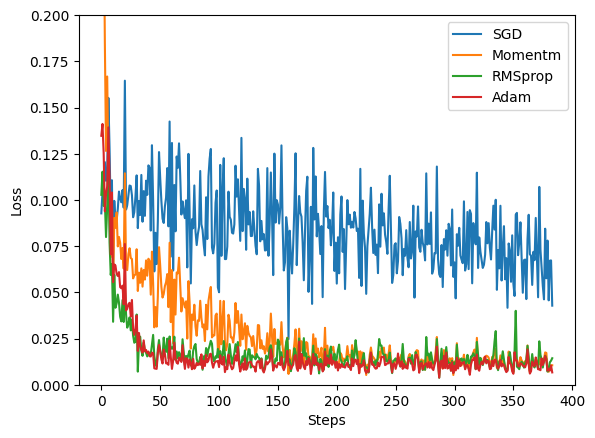

In [39]:
# 图形化展示
labels = ["SGD", "Momentm", "RMSprop", "Adam"]
for i, l in enumerate(loss_his):
    plt.plot(l, label=labels[i])
plt.legend(loc = 'best')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.ylim((0, 0.2))
plt.show()